# Importing Training and Testing Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('data/train.csv')

X_t = train_data.drop(['category', 'ID'], axis=1)
y_t = train_data['category']

test_data = pd.read_csv('data/test.csv')

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.1, random_state=42)

# Approach 2: Pipelining the process

In [2]:
import metaclass as mc
import pipeline_components as pc
import importlib
importlib.reload(mc)

<module 'metaclass' from '/Users/Atharv/Documents/uni/Semester 4/CSE342 - Statistical Machine Learning [SML]/Project/SML-Project/metaclass.py'>

In [ ]:
pipeline = mc.Pipeline(
    clustering_alg=("kmeans", 4),
    dim_reduction_algs=[("pca", 350), ("lda", 19)],
    outlier_detection_alg=None,
    classification_alg="logistic",
    ensemble_algs=["bagging"],
)
# pipeline.fit(X_t, y_t)
pipeline.fit(X_train, y_train)
print("Pipeline done")

# cv_scores = pipeline.cross_validate(X_t, y_t, n_splits=5)
# print("Cross validation scores: ", cv_scores)

In [ ]:
# Training accuracy
y_pred = pipeline.predict(X_test)
print("Validation accuracy: ", np.sum(y_pred == y_test) / len(y_test))

# 255 pca, 1 lda, logistic, no ensemble
# cv_scores

In [ ]:
# pipeline.generate_submission(test_data)

# Approach 3 - New Pipeline

# Imports

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from pipeline_components import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV

In [3]:
import csv
import sys

def generate_submission(pipeline, test_data):
    from datetime import datetime

    X_test = test_data.drop(['ID'], axis=1)
    y_pred = pipeline.predict(X_test)

    submission = pd.DataFrame({'ID': test_data['ID'], 'Category': y_pred})
    filename = f"./submissions/submission_{(datetime.now()).strftime('%Y_%m_%d-%H_%M')}.csv"
    submission.to_csv(filename, index=False)

    return filename

def compare_csv(file1, file2):
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        reader1 = csv.reader(f1)
        reader2 = csv.reader(f2)
        count = 0
        for row1, row2 in zip(reader1, reader2):
            if row1 != row2:
                count += 1
    return count

In [4]:
def apply_dbscan(X, eps=5.7, min_samples=5):
    # apply dbscan on a dataset of 19 features and 1000 samples
    
    clus = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = clus.fit_predict(X)
    X = np.c_[X, y_pred]
    return X
    # add cluster label as a new feature to the dataset 

def apply_kmeans(X, n_clusters):
    clus = KMeans(n_clusters=n_clusters)
    y_pred = clus.fit_predict(X)
    X = np.c_[X, y_pred]
    return X
    # add cluster label as a new feature to the dataset

def apply_lof(X, n_neighbors):
    clus = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
    # remove the outliers
    y_pred = clus.fit_predict(X)
    X = X[y_pred == 1]
    print("New X.shape:", X.shape)
    return X
    # add cluster label as a new feature to the dataset
X_t.shape

(1216, 4096)

In [45]:
pipeline = Pipeline([
    ("PCA", PCA(n_components=415, random_state=None)),
    ("LDA", LinearDiscriminantAnalysis(n_components=19)),
    # ("StandardScaler", StandardScaler()), # This appears to be hurting performance
    ("dbscan", FunctionTransformer(apply_dbscan, validate=False, kw_args={'eps': 0.5, 'min_samples': 5})),
    ("LR", LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, random_state=42)), 
    # ("bagging", BaggingClassifier(estimator=(
    #     LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=10000, random_state=0)), 
    #     n_estimators=80, max_samples=0.8, max_features=0.8, bootstrap=True, bootstrap_features=False, random_state=0)),
    ])


# MLPClassifier(activation='relu', solver='lbfgs', alpha=10, hidden_layer_sizes=(319), random_state=1)

pipeline.fit(X_t, y_t)
print("Pipeline done")
cross_val_scores=cross_val_score(pipeline, X_t, y_t, cv=5)

Pipeline done


In [46]:
print("Cross validation accuracy:", cross_val_scores.mean(), cross_val_scores.std())
y_pred = pipeline.predict(X_test)
print("Training accuracy: ", np.sum(y_pred == y_test) / len(y_test))

Cross validation accuracy: 0.7870201713553262 0.011771888218301677
Training accuracy:  0.9918032786885246


In [47]:
filename = generate_submission(pipeline, test_data)
diff_count_1 = compare_csv(r'./submissions/submission_2023_04_14-23_30.csv', filename)
diff_count_2 = compare_csv(r'./submissions/prakhar.csv', filename)
print(f'There are {diff_count_1} different lines between our best csv and {filename}.')
print(f'There are {diff_count_2} different lines between prakhar.csv and {filename}.')

There are 20 different lines between our best csv and ./submissions/submission_2023_04_17-01_26.csv.
There are 24 different lines between prakhar.csv and ./submissions/submission_2023_04_17-01_26.csv.


In [ ]:
# Apply grid search to find the best parameters for the pipeline
param_grid = {
    'dbscan__min_samples': [5, 6, 7, 8, 9, 10],
    'bagging__n_estimators': [[i for i in range(10, 200, 10)]],
    'bagging__max_samples': [0.5, 0.8, 1.0],
    'bagging__max_features': [0.5, 0.8, 1.0],
    'bagging__bootstrap': [True, False],
    'bagging__bootstrap_features': [False, True],
    'bagging__random_state': [42, 0],
}
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, verbose=1)

In [ ]:
grid_search.fit(X_t, y_t)
print("Grid search done")

In [ ]:
print("Best parameters: ", grid_search.best_params_)

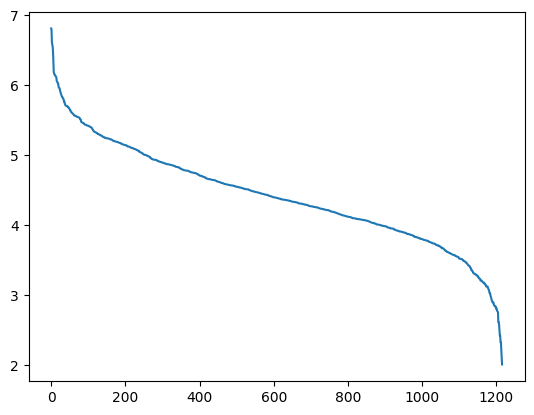

In [ ]:
def compute_k_distance_graph(X, k):
    from sklearn.neighbors import NearestNeighbors
    import matplotlib.pyplot as plt

    # Assume X is your dataset
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)

    # Sort the distances for each point
    distances = np.sort(distances, axis=0)[::-1]

    # Plot the k-distance graph
    plt.plot(distances[:, -1])
    plt.show()

# apply PCA and LDA on X_t
def apply_pca_lda(X, y):
    pipeline = Pipeline([
        ("PCA 415", PCA(n_components=415)),
        ("LDA 19", LinearDiscriminantAnalysis(n_components=19)),
    ])
    return pipeline.fit_transform(X, y)

compute_k_distance_graph(apply_pca_lda(X_t, y_t), 5)